# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q5"> 5. What significant does the family violence factor play, in violent crime, over time? 
><li><a href="#q6"> 6. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns 
import warnings

plt.style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 
              None)

In [2]:
# Loading the data
df = pd.read_csv('crime_reports.csv')

In [3]:
# Examining the dataframe
display(df.info())
print('----------------------------------')
display(df.duplicated().sum())
print('----------------------------------')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277186 entries, 0 to 2277185
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

None

----------------------------------


0

----------------------------------


Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20861
Address                             12
Zip Code                         13891
Council District                 47007
APD Sector                        8814
APD District                      9284
PRA                              10524
Census Tract                   1466019
Clearance Status                603439
Clearance Date                  334230
UCR Category                   1502526
Category Description           1502526
X-coordinate                      9947
Y-coordinate                      9947
Latitude                         38411
Longitude                

## II. Data Scrubbing

There are several columns of data we don't need. We'll drop those and also scrub the Columns were keeping for analysis. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

The 'clearance status' column contains 3 types of statuses: Y for Yes, N for No, and O which stands for "cleared by other means than arrest." Therefore, I changed it to boolean type:  Y and O as True, and N as False. However, you may note that areas, where there is no clearance status at all, may or may not contain a corresponding date in the clearance date column. I am unsure how best to handle this so I am open to suggestions or advice. I also converted the 'family violence' column to boolean type.  

In [4]:
# Script for scrubbing the data
def clean_data(df):
    drop_col = ['Occurred Time', 
                'Occurred Date', 
                'Report Date', 
                'Report Time', 
                'Census Tract', 
                'UCR Category', 
                'Category Description', 
                'X-coordinate', 
                'Y-coordinate', 
                'Location']
    df.drop(drop_col, 
            axis=1, 
            inplace=True)
    #clean_col = ['Zip Code', 
    #            'Report Date Time', 
    #             'Occurred Date Time'] 
    #df.dropna(subset =clean_col, 
    #          inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", 
                                                          "_"), 
              inplace=True)
    """Convert the following to bools"""
    d = {'Y': True, 
         'N': False}
    e = {'C': True, 
         'O': True, 
         'N': False}
    df.clearance_status = df.clearance_status.map(e)
    df.clearance_status = df.clearance_status.astype('bool')
    df.family_violence  = df.family_violence.map(d)
    df.family_violence  = df.family_violence.astype('bool') 
    """Convert the following to datetime type"""
    date_col = ['occurred_date_time', 
                'clearance_date', 
                'report_date_time'] 
    """Convert the following to category type"""
    cat_col  = ['highest_offense_description', 
                'location_type', 
                'apd_sector', 
                'pra', 
                'council_district', 
                'zip_code'] 
    df[date_col] = df[date_col].astype('datetime64') 
    df[cat_col]  = df[cat_col].astype('category') 
    """Creating new time columns and an index out of the 'occured date time' column"""
    df['year']  = pd.to_datetime(df['occurred_date_time'], 
                                 format='%m/%d/%Y').dt.year 
    df['month'] = pd.to_datetime(df['occurred_date_time'], 
                                 format='%m/%d/%Y').dt.month
    df['week']  = pd.to_datetime(df['occurred_date_time'], 
                                 format='%m/%d/%Y').dt.week
    df['day']   = pd.to_datetime(df['occurred_date_time'], 
                                 format='%m/%d/%Y').dt.day
    df['hour']  = pd.to_datetime(df['occurred_date_time'], 
                                 format='%m/%d/%Y').dt.hour
    df.set_index(['occurred_date_time'], 
                 inplace=True)
    df.sort_index(inplace=True)
    return df
df = clean_data(df)

In [5]:
# Rechecking the dataframe 
display(df.isnull().sum())
print('----------------------------------')
display(df.dtypes)
print('----------------------------------')
display(df.head())
print('----------------------------------')
display(df.tail())

incident_number                     0
highest_offense_description         0
highest_offense_code                0
family_violence                     0
report_date_time                    1
location_type                   20861
address                            12
zip_code                        13891
council_district                47007
apd_sector                       8814
apd_district                     9284
pra                             10524
clearance_status                    0
clearance_date                 334230
latitude                        38411
longitude                       38411
year                              165
month                             165
week                              165
day                               165
hour                              165
dtype: int64

----------------------------------


incident_number                         int64
highest_offense_description          category
highest_offense_code                    int64
family_violence                          bool
report_date_time               datetime64[ns]
location_type                        category
address                                object
zip_code                             category
council_district                     category
apd_sector                           category
apd_district                           object
pra                                  category
clearance_status                         bool
clearance_date                 datetime64[ns]
latitude                              float64
longitude                             float64
year                                  float64
month                                 float64
week                                  float64
day                                   float64
hour                                  float64
dtype: object

----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,,,
2003-01-01,20085024074,IDENTITY THEFT,4022,False,2008-05-10 18:36:00,RESIDENCE / HOME,7312 WHISPERING OAKS DR,78745.0,5.0,FR,1,525,True,2008-05-13,30.202175,-97.817542,2003.0,1.0,1.0,1.0,0.0
2003-01-01,20135010506,IDENTITY THEFT,4022,False,2013-03-11 17:28:00,RESIDENCE / HOME,7001 S CONGRESS AVE,78745.0,2.0,FR,3,528,False,2013-03-12,30.188878,-97.780075,2003.0,1.0,1.0,1.0,0.0
2003-01-01,20095044565,IDENTITY THEFT,4022,False,2009-08-07 14:23:00,RESIDENCE / HOME,6800 MC NEIL DR,78729.0,6.0,AD,4,169,True,NaT,30.438983,-97.759669,2003.0,1.0,1.0,1.0,0.0
2003-01-01,20055067732,IDENTITY THEFT,4022,False,2005-02-14 17:30:00,COMMERCIAL / OFFICE BUILDING,715 E 8TH ST,78701.0,9.0,GE,2,382,True,NaT,30.267553,-97.734674,2003.0,1.0,1.0,1.0,0.0
2003-01-01,20125003299,IDENTITY THEFT,4022,False,2012-01-23 09:41:00,SPECIALTY STORE (TV FUR ETC.),1533 CUTTING HORSE LN,78727.0,7.0,ED,4,193,False,2012-01-23,30.416668,-97.683656,2003.0,1.0,1.0,1.0,0.0


----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,week,day,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,,,
NaT,2003924001333,AUTO THEFT,700,False,2003-01-17 23:05:00,PARKING LOTS / GARAGE,6855 E US 290 HWY SVRD EB,78723.0,1.0,ID,3,294,False,NaT,30.320667,-97.687671,NaN,NaN,NaN,NaN,NaN
NaT,20063470166,DAMAGE CITY PROP,3817,False,2006-12-13 02:19:00,NaN,812 SPRINGDALE RD,78702.0,3.0,CH,2,422,False,2007-02-13,30.258932,-97.699980,NaN,NaN,NaN,NaN,NaN
NaT,2003924135761,BURGLARY OF VEHICLE,601,False,2003-05-31 13:58:00,PARKING LOTS / GARAGE,9400 W PARMER LN,78717.0,6.0,AD,5,574,False,NaT,30.480812,-97.766068,NaN,NaN,NaN,NaN,NaN
NaT,20051441760,SUSPICIOUS PERSON,3403,False,2005-05-24 20:14:00,NaN,8200 GEORGIAN DR,78753.0,4.0,ED,1,250,False,2005-06-28,30.347657,-97.703221,NaN,NaN,NaN,NaN,NaN
NaT,2003924546553,DAMAGE CITY PROP,3817,False,2003-05-12 10:17:00,STREETS / HWY / ROAD / ALLEY,600 TRINITY ST,78701.0,9.0,GE,2,381,False,2003-05-12,30.267184,-97.739377,NaN,NaN,NaN,NaN,NaN


## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

### Overall crime rates over time 

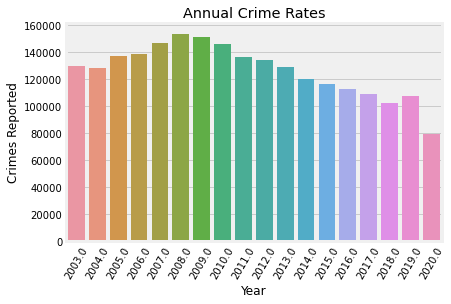

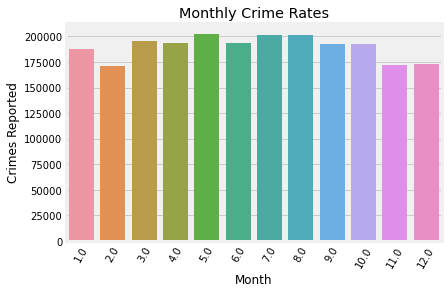

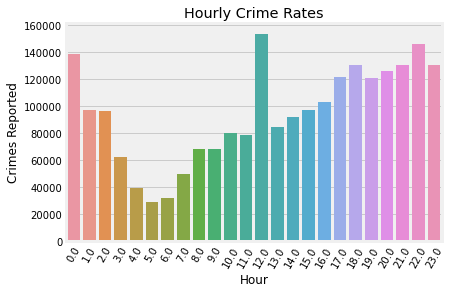

In [6]:
figsize=(20,10)

# Creating and visualizing a data frame for the overall yearly crime rate since 2003
crimes_per_year = df['year'].value_counts().sort_index() 

g = sns.barplot(x=crimes_per_year.index, 
                y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), 
                  rotation=60)
g.set(xlabel='Year', 
      ylabel='Crimes Reported', 
      title ='Annual Crime Rates')
plt.show()

# Creating and visualizing a data frame for the overall yearly crime rate since 2003
crimes_per_month = df['month'].value_counts().sort_index() 

d = sns.barplot(x=crimes_per_month.index, 
                y=crimes_per_month.values)
d.set_xticklabels(d.get_xticklabels(), 
                  rotation=60)
d.set(xlabel='Month', 
      ylabel='Crimes Reported', 
      title ='Monthly Crime Rates')
plt.show()

# Overall hourly crime rates as well
crimes_per_hour = df['hour'].value_counts().sort_index()

e = sns.barplot(x=crimes_per_hour.index, 
                y=crimes_per_hour.values)
e.set_xticklabels(e.get_xticklabels(), 
                  rotation=60)
e.set(xlabel='Hour', 
      ylabel='Crimes Reported', 
      title ='Hourly Crime Rates')
plt.show()

### Top 50 crime types 

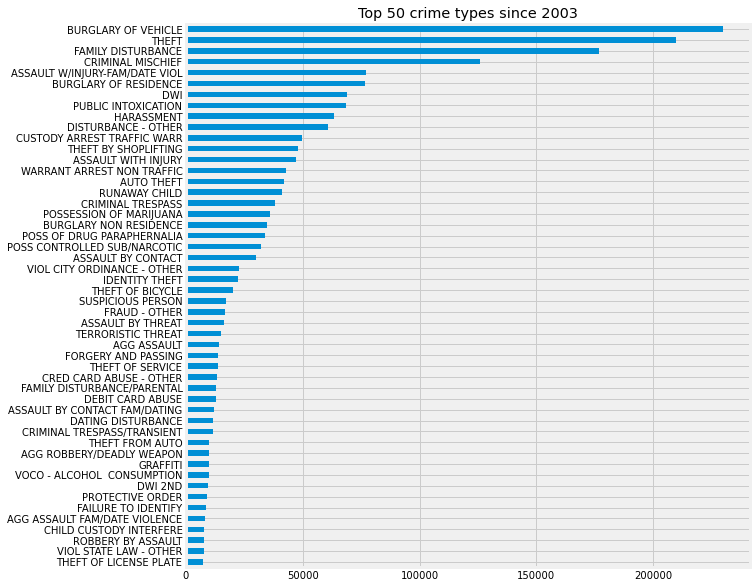

In [7]:
df.highest_offense_description.value_counts().head(50).sort_values().plot.barh(figsize=(9,10), 
                                                                               title ='Top 50 crime types since 2003')

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    204849
78753.0    176853
78701.0    167212
78758.0    157262
78704.0    153094
78745.0    149308
78702.0    135840
78744.0    125019
78723.0    117154
78752.0     83710
78748.0     67248
78759.0     65489
78751.0     63451
78757.0     57156
78705.0     56459
78721.0     47275
78749.0     40009
78724.0     37299
78727.0     35436
78703.0     34851
78731.0     28297
78746.0     27910
78729.0     25347
78750.0     23361
78754.0     22438
Name: zip_code, dtype: int64

----------------------------------


78741.0    0.090509
78753.0    0.078140
78701.0    0.073880
78758.0    0.069484
78704.0    0.067642
78745.0    0.065969
78702.0    0.060019
78744.0    0.055238
78723.0    0.051763
78752.0    0.036986
78748.0    0.029712
78759.0    0.028935
78751.0    0.028035
78757.0    0.025253
78705.0    0.024945
78721.0    0.020888
78749.0    0.017677
78724.0    0.016480
78727.0    0.015657
78703.0    0.015398
78731.0    0.012503
78746.0    0.012332
78729.0    0.011199
78750.0    0.010322
78754.0    0.009914
Name: zip_code, dtype: float64

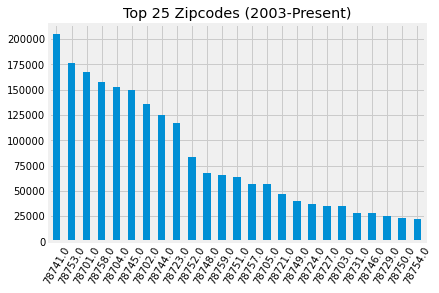

In [8]:
# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print('----------------------------------')
display(df.zip_code.value_counts(normalize=True).head(25))


# Visualizing the top 25 areas for crime 
df.zip_code.value_counts().head(25).plot.bar(rot=60, 
                                             title='Top 25 Zipcodes (2003-Present)')
plt.show()

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.14%. This is a significant 1.29 percentage points higher than the number 2 area 78753 which hosts 7.85% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             16992
BURGLARY OF VEHICLE               15851
FAMILY DISTURBANCE                14433
CRIMINAL MISCHIEF                  9315
THEFT BY SHOPLIFTING               7549
ASSAULT W/INJURY-FAM/DATE VIOL     7057
BURGLARY OF RESIDENCE              6021
DWI                                4913
DISTURBANCE - OTHER                4704
CUSTODY ARREST TRAFFIC WARR        4336
HARASSMENT                         4184
AUTO THEFT                         4108
POSS OF DRUG PARAPHERNALIA         3714
PUBLIC INTOXICATION                3354
ASSAULT WITH INJURY                3260
CRIMINAL TRESPASS                  3112
POSS CONTROLLED SUB/NARCOTIC       2947
RUNAWAY CHILD                      2906
WARRANT ARREST NON TRAFFIC         2786
POSSESSION OF MARIJUANA            2686
BURGLARY NON RESIDENCE             2460
VIOL CITY ORDINANCE - OTHER        1864
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096080
BURGLARY OF VEHICLE               0.089628
FAMILY DISTURBANCE                0.081610
CRIMINAL MISCHIEF                 0.052671
THEFT BY SHOPLIFTING              0.042685
ASSAULT W/INJURY-FAM/DATE VIOL    0.039903
BURGLARY OF RESIDENCE             0.034045
DWI                               0.027780
DISTURBANCE - OTHER               0.026598
CUSTODY ARREST TRAFFIC WARR       0.024518
HARASSMENT                        0.023658
AUTO THEFT                        0.023228
POSS OF DRUG PARAPHERNALIA        0.021000
PUBLIC INTOXICATION               0.018965
ASSAULT WITH INJURY               0.018433
CRIMINAL TRESPASS                 0.017597
POSS CONTROLLED SUB/NARCOTIC      0.016664
RUNAWAY CHILD                     0.016432
WARRANT ARREST NON TRAFFIC        0.015753
POSSESSION OF MARIJUANA           0.015188
BURGLARY NON RESIDENCE            0.013910
VIOL CITY ORDINANCE - OTHER       0.010540
Name: highest_offense_description, dtype: float64

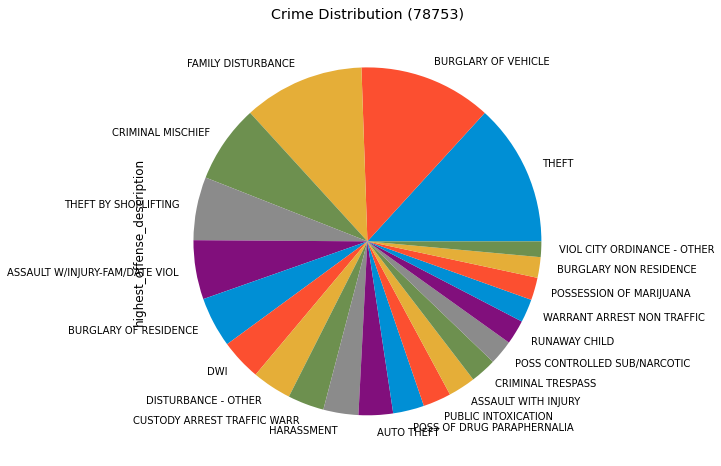

In [9]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages 
display(df_53_off)
print('----------------------------------')
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8,8), 
                   title ='Crime Distribution (78753)')

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                20093
BURGLARY OF VEHICLE               19707
THEFT                             15449
CRIMINAL MISCHIEF                 10942
ASSAULT W/INJURY-FAM/DATE VIOL     9562
BURGLARY OF RESIDENCE              8827
PUBLIC INTOXICATION                6364
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5617
HARASSMENT                         5440
DISTURBANCE - OTHER                5113
AUTO THEFT                         4525
ASSAULT WITH INJURY                4495
CRIMINAL TRESPASS                  3866
POSS CONTROLLED SUB/NARCOTIC       3825
POSSESSION OF MARIJUANA            3785
THEFT BY SHOPLIFTING               3561
POSS OF DRUG PARAPHERNALIA         3523
WARRANT ARREST NON TRAFFIC         3449
RUNAWAY CHILD                      2778
VIOL CITY ORDINANCE - OTHER        2195
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098087
BURGLARY OF VEHICLE               0.096203
THEFT                             0.075417
CRIMINAL MISCHIEF                 0.053415
ASSAULT W/INJURY-FAM/DATE VIOL    0.046678
BURGLARY OF RESIDENCE             0.043090
PUBLIC INTOXICATION               0.031067
CUSTODY ARREST TRAFFIC WARR       0.029344
DWI                               0.027420
HARASSMENT                        0.026556
DISTURBANCE - OTHER               0.024960
AUTO THEFT                        0.022089
ASSAULT WITH INJURY               0.021943
CRIMINAL TRESPASS                 0.018872
POSS CONTROLLED SUB/NARCOTIC      0.018672
POSSESSION OF MARIJUANA           0.018477
THEFT BY SHOPLIFTING              0.017384
POSS OF DRUG PARAPHERNALIA        0.017198
WARRANT ARREST NON TRAFFIC        0.016837
RUNAWAY CHILD                     0.013561
VIOL CITY ORDINANCE - OTHER       0.010715
Name: highest_offense_description, dtype: float64

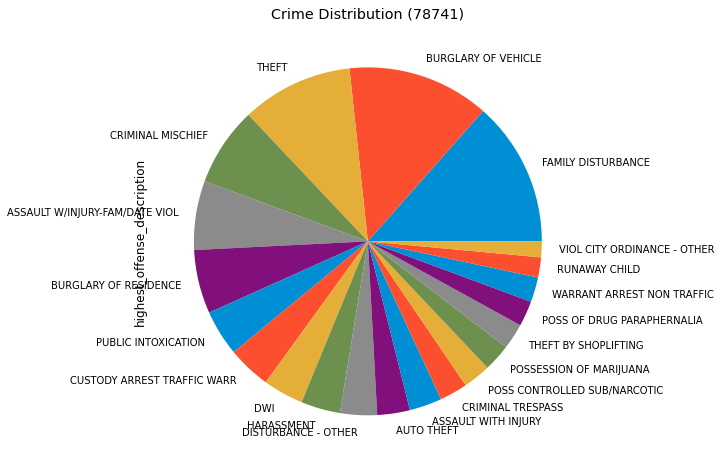

In [10]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages 
display(df_41_off)
print('----------------------------------')
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8,8), 
                   title ='Crime Distribution (78741)')

<a id='q4'></a>
### D. Question 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

***The following line of code shows crime rates only >= 1% per zipcode.***

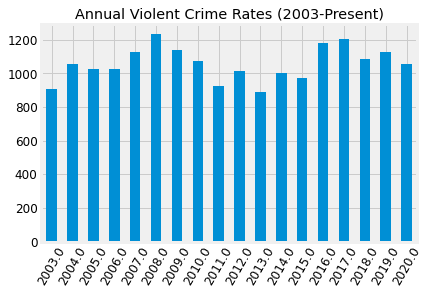

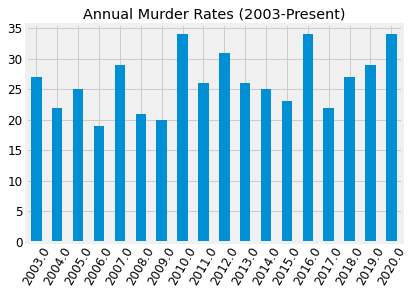

78741.0    0.115124
78701.0    0.098019
78753.0    0.092671
78758.0    0.082980
78702.0    0.074508
78723.0    0.067041
78745.0    0.059521
78744.0    0.054067
78704.0    0.050784
78752.0    0.046336
78721.0    0.031455
78724.0    0.027801
78705.0    0.025577
78757.0    0.019434
78748.0    0.018587
78751.0    0.017210
78759.0    0.012868
78749.0    0.008738
78617.0    0.008473
78722.0    0.008261
78754.0    0.008102
78727.0    0.007784
78729.0    0.007626
78750.0    0.005613
78731.0    0.005507
Name: zip_code, dtype: float64

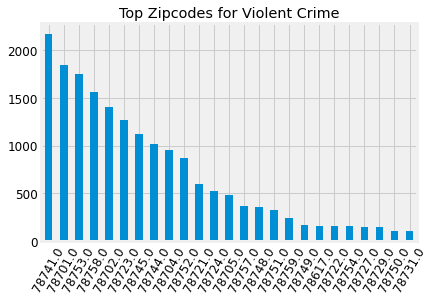

78753.0    0.109937
78741.0    0.105708
78723.0    0.095137
78758.0    0.093023
78744.0    0.069767
78745.0    0.059197
78752.0    0.057082
78702.0    0.057082
78701.0    0.040169
78704.0    0.038055
78721.0    0.033827
78724.0    0.029598
78749.0    0.023256
78757.0    0.016913
78751.0    0.016913
78705.0    0.016913
78727.0    0.014799
78759.0    0.014799
78748.0    0.014799
78617.0    0.012685
78754.0    0.012685
78731.0    0.010571
78747.0    0.008457
78750.0    0.008457
78735.0    0.006342
Name: zip_code, dtype: float64

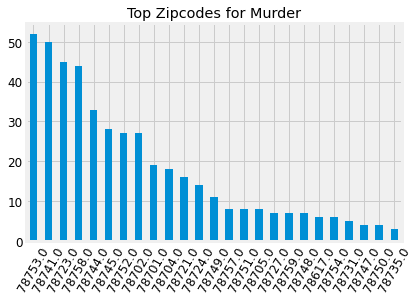

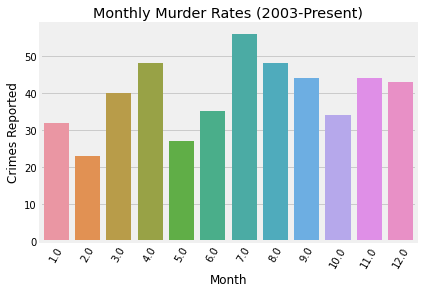

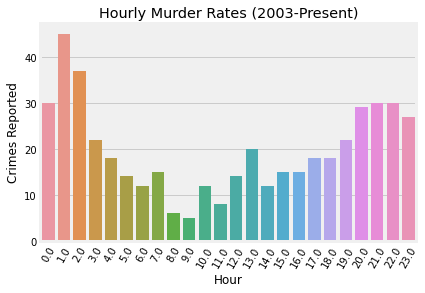

highest_offense_description,AGG ASSAULT,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,
78610.0,1,0,0,0
78613.0,14,0,1,6
78617.0,118,0,6,36
78621.0,1,0,0,0
78634.0,1,0,0,0
78652.0,2,0,0,0
78653.0,10,0,1,1
78660.0,66,0,2,17
78664.0,3,0,0,0


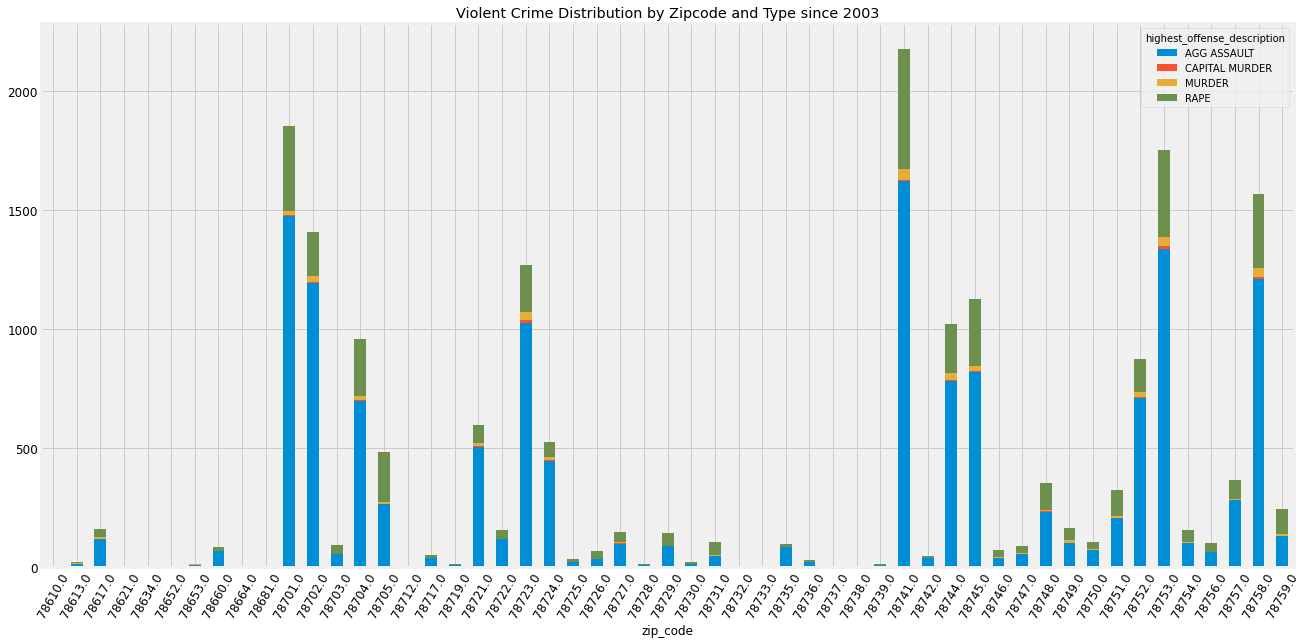

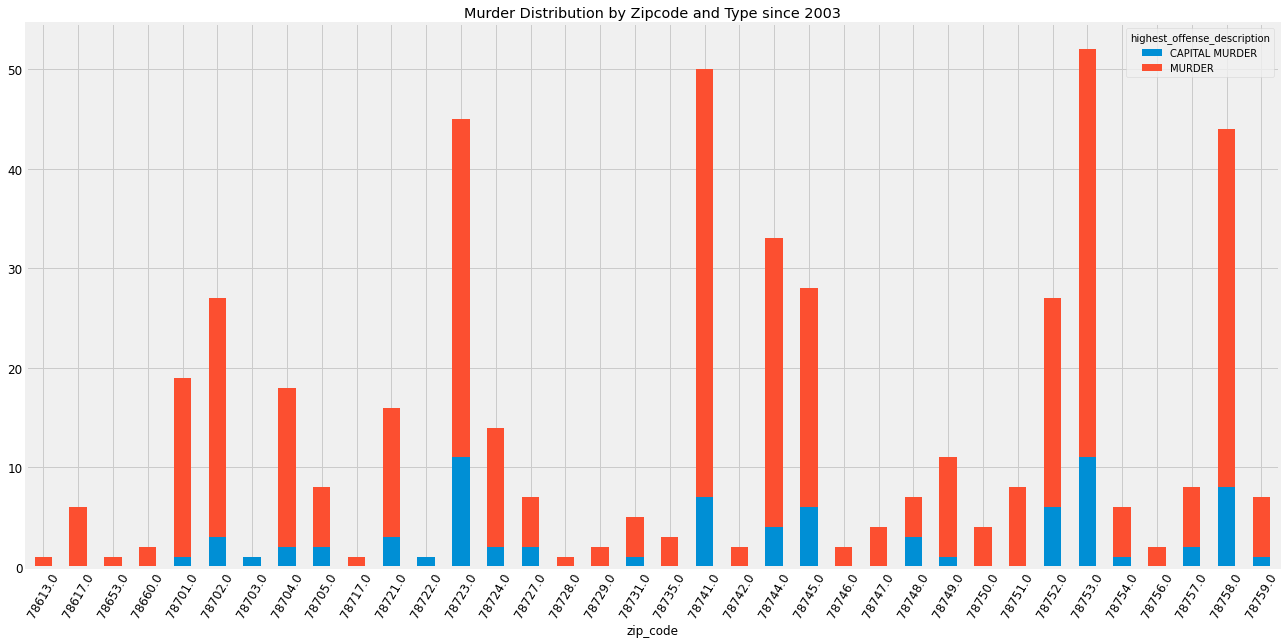

In [11]:
# Creating an overall and separate dataframes for violent crime
df_viol = df.query('highest_offense_description     == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]') 
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description          == 'MURDER']
df_mur_cap = df[df.highest_offense_description      == 'CAPITAL MURDER']
df_agg_asslt = df[df.highest_offense_description    == 'AGG ASSAULT']
df_rape = df[df.highest_offense_description         == 'RAPE']


# Visualizing violent crimes per year
viol_per_year = df_viol['year'].value_counts().sort_index()
viol_per_year.plot.bar(rot=60,
                       title='Annual Violent Crime Rates (2003-Present)', 
                       fontsize=12)
plt.show()

# Visualizing murders per year
viol_mur_per_year = df_viol_mur.year.value_counts().sort_index()
viol_mur_per_year.plot.bar(rot=60,
                           title='Annual Murder Rates (2003-Present)', 
                           fontsize=12)
plt.show()

#Violent Crime by Zipcode
display(df_viol.zip_code.value_counts(normalize=True).head(25))
df_viol.zip_code.value_counts().head(25).plot.bar(title='Top Zipcodes for Violent Crime', 
                                                  fontsize=12, 
                                                  rot=60)
plt.show()

# Murder by Zipcode
display (df_viol_mur.zip_code.value_counts(normalize=True).head(25))
df_viol_mur.zip_code.value_counts().head(25).plot.bar(fontsize=12, 
                                                      title='Top Zipcodes for Murder', 
                                                      rot=60)
plt.show()
        
mur_by_month = df_viol_mur['month'].value_counts().sort_index()
mur_by_hour = df_viol_mur['hour'].value_counts().sort_index()

# Visualizing monthly & hourly murder rate with Seaborn
v = sns.barplot(x=mur_by_month.index, 
                y=mur_by_month.values)
v.set_xticklabels(v.get_xticklabels(), 
                  rotation=60)
v.set(xlabel='Month', 
      ylabel='Crimes Reported', 
      title ='Monthly Murder Rates (2003-Present)')
plt.show()

f = sns.barplot(x=mur_by_hour.index, 
                y=mur_by_hour.values)
f.set_xticklabels(f.get_xticklabels(), 
                  rotation=60)
f.set(xlabel='Hour', 
      ylabel='Crimes Reported', 
      title ='Hourly Murder Rates (2003-Present)')
plt.show()

# Calculating and visualizing frequency rate of violent crimes by zipcode
viol_freq = pd.crosstab(df_viol.zip_code, 
                        df_viol.highest_offense_description)

display(viol_freq)

viol_freq.plot.bar(figsize=figsize, 
                   title='Violent Crime Distribution by Zipcode and Type since 2003', 
                   fontsize=12, 
                   stacked=True, 
                   rot=60)
plt.show()

viol_mur_freq = pd.crosstab(df_viol_mur.zip_code, 
                            df_viol_mur.highest_offense_description)

viol_mur_freq.plot.bar(figsize=figsize, 
                       title='Murder Distribution by Zipcode and Type since 2003', 
                       fontsize=12, 
                       stacked=True,  
                       rot=60)
plt.show()

In [12]:
viol_freq.to_csv('viol_freq.csv')

According to the data , 2010 and 2016 had the most number of murders . Alarmingly, as of 10/19/2020, murders already totaled 34--the same amount for 2016 and 2010!!

<a id='q5'></a>
### E. Question 5. What significance has the family violence factor played over time? 

0.05824337581558994

----------------------------------


occurred_date_time
2003.0    0.039299
2004.0    0.044946
2005.0    0.049336
2006.0    0.054058
2007.0    0.058603
2008.0    0.058205
2009.0    0.055023
2010.0    0.052693
2011.0    0.060294
2012.0    0.061567
2013.0    0.058016
2014.0    0.057432
2015.0    0.062406
2016.0    0.066051
2017.0    0.067742
2018.0    0.074100
2019.0    0.070141
2020.0    0.075019
Name: family_violence, dtype: float64

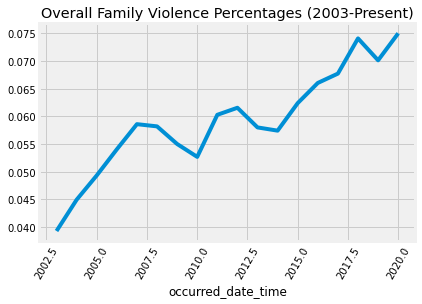

0.07829144146507845

----------------------------------


occurred_date_time
2003    0.035165
2004    0.036053
2005    0.048685
2006    0.042760
2007    0.056738
2008    0.068994
2009    0.066725
2010    0.062268
2011    0.078834
2012    0.083579
2013    0.111111
2014    0.123876
2015    0.127572
2016    0.101695
2017    0.096346
2018    0.112236
2019    0.083333
2020    0.074811
Name: family_violence, dtype: float64

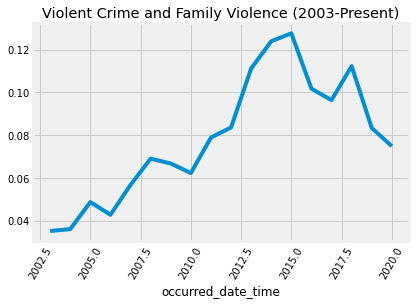

0.20675105485232068

----------------------------------


occurred_date_time
2003    0.148148
2004    0.090909
2005    0.320000
2006    0.105263
2007    0.068966
2008    0.238095
2009    0.050000
2010    0.264706
2011    0.230769
2012    0.225806
2013    0.307692
2014    0.240000
2015    0.304348
2016    0.117647
2017    0.181818
2018    0.222222
2019    0.344828
2020    0.205882
Name: family_violence, dtype: float64

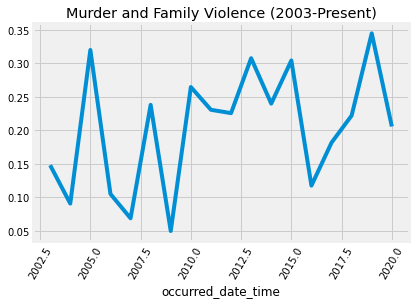

0.22797202797202798

----------------------------------


occurred_date_time
2003    0.154321
2004    0.082949
2005    0.107692
2006    0.125000
2007    0.169355
2008    0.189873
2009    0.202586
2010    0.168033
2011    0.261111
2012    0.274112
2013    0.277512
2014    0.271468
2015    0.282209
2016    0.327402
2017    0.284768
2018    0.247557
2019    0.263830
2020    0.303030
Name: family_violence, dtype: float64

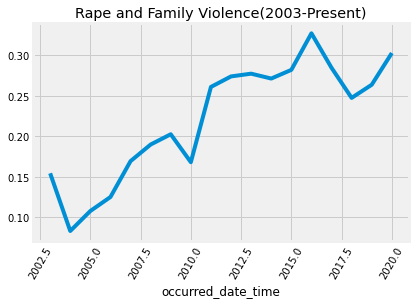

0.22797202797202798

----------------------------------


occurred_date_time
2003    0.004161
2004    0.022086
2005    0.026022
2006    0.022005
2007    0.023502
2008    0.035934
2009    0.031567
2010    0.021303
2011    0.027778
2012    0.030418
2013    0.050305
2014    0.032520
2015    0.040128
2016    0.027746
2017    0.029545
2018    0.053121
2019    0.025463
2020    0.025671
Name: family_violence, dtype: float64

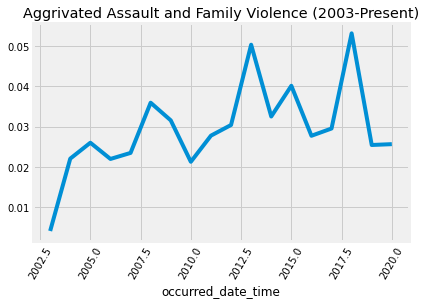

In [13]:
# Taking a look at first at the overall crime set
display(df.family_violence.mean())

print('----------------------------------')
display(df.groupby(df.index.year).family_violence.mean())

hrly_fam_viol_occurrences = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg.plot(rot=60, 
                  title='Overall Family Violence Percentages (2003-Present)')
plt.show()

# Now taking a look at violent crime specifically 
display(df_viol.family_violence.mean())

print('----------------------------------')
display(df_viol.groupby(df_viol.index.year).family_violence.mean())

viol_hrly_fam_viol_occurrences = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg.plot(rot=60, 
                       title='Violent Crime and Family Violence (2003-Present)')
plt.show()

# Now taking a look at murder with the family violence factor included 
display(df_viol_mur.family_violence.mean())

print('----------------------------------')
display(df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean())

mur_hrly_fam_viol_occurrences = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg.plot(rot=60, 
                      title='Murder and Family Violence (2003-Present)')
plt.show()

# Now taking a look at rape with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_rape.groupby(df_rape.index.year).family_violence.mean())

rape_hrly_fam_viol_occurrences = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg.plot(rot=60, 
                       title='Rape and Family Violence(2003-Present)')
plt.show()

# Now taking a look at aggrivated assault with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean())

agg_asslt_fam_viol_avg = df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean()

agg_asslt_fam_viol_avg.plot(rot=60, 
                            title='Aggrivated Assault and Family Violence (2003-Present)')
plt.show()

Overall, family violence is seeing an upward trend as a crime factor. Violent crime saw an alarming upward trend of the family violence factor, as well. Rapes, for example, involved the family violence factor a 3rd of the time in 2016 whereas in 2004, family violence was involved less than 1% of the time. 

<a id='q6'></a>
### F. Question 6. How does murder appear on the map? 

In [14]:
# As a heatmap
mur_coords_heat = df_viol_mur[(df_viol_mur['latitude'].isnull() == False) 
                           & (df_viol_mur['longitude'].isnull() == False)]

k = folium.Map(location=[30.2672, -97.7431], 
               tiles='OpenStreetMap', 
               zoom_start=11) 
                         
k.add_child(plugins.HeatMap(mur_coords_heat[['latitude', 
                                             'longitude']].values, 
                            radius=15))

k.save(outfile='aus_mur_heatmap.html')

k

In [15]:
# Pinpointing individual addresses
mur_coords_add  = df_viol_mur[(df_viol_mur['latitude'].isnull() == False) 
                           & (df_viol_mur['longitude'].isnull() == False)]

# Making a folium map using incident lat and lon
m = folium.Map([30.2672, -97.7431], 
               tiles='Stamen Toner', 
               zoom_level=12)

for index, row in mur_coords_add.iterrows():
	lat = row['latitude']
	lon = row['longitude']
	name= row['address']
	folium.Marker([lat, lon], 
                  popup=name).add_to(m)
    
m.save(outfile='aus_mur_map.html')

m

## Are there any addresses where murder occurs frequently?

In [16]:
df_viol_mur.address.value_counts().head(31)

8610 N LAMAR BLVD            3
6407 SPRINGDALE RD           3
6409 SPRINGDALE RD           3
8800 N IH 35 SVRD SB         3
4700 E RIVERSIDE DR          3
2400 WICKERSHAM LN           2
815 W SLAUGHTER LN           2
2501 ANKEN DR                2
201 W 5TH ST                 2
2508 E RIVERSIDE DR          2
9601 MIDDLE FISKVILLE RD     2
2915 S IH 35 SVRD NB         2
833 FAIRFIELD DR             2
2101 ELMONT DR               2
6600 ED BLUESTEIN BLVD SB    2
605 MASTERSON PASS           2
1050 SPRINGDALE RD           2
8225 SAM RAYBURN DR          2
6118 FAIRWAY ST              2
9200 NORTH PLZ               2
2713 S CONGRESS AVE          2
601 E 15TH ST                2
10610 MORADO CIR             2
744 W WILLIAM CANNON DR      2
8912 N LAMAR BLVD            2
7000 DECKER LN               2
1711 RUTLAND DR              2
10503 N LAMAR BLVD           2
1137 GUNTER ST               2
9010 GALEWOOD DR             2
9220 N IH 35 SVRD SB         2
Name: address, dtype: int64

In [17]:
temp = df.groupby(['zip_code', 'year'])['location_type'].count().sort_values(ascending=False).reset_index()
df2 = temp.pivot('zip_code', 'year', 'location_type')
df2 = df2.fillna(0)

In [18]:
df_viol_mur.to_csv('datasets\df_viol_mur.csv')

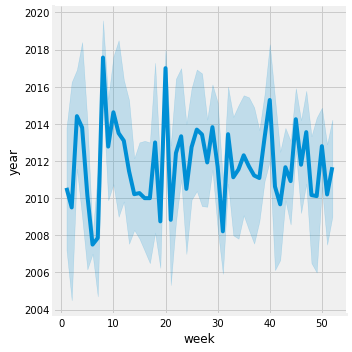

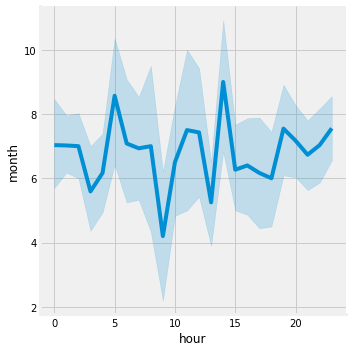

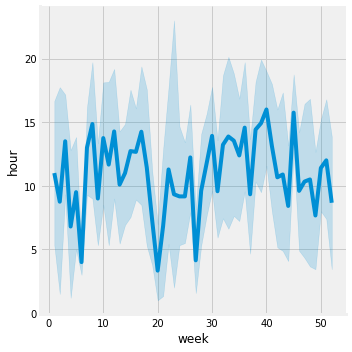

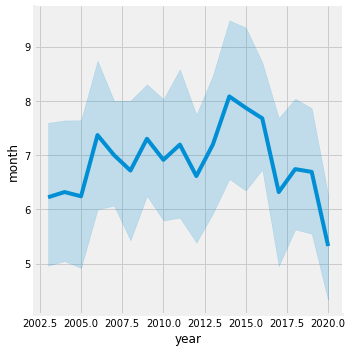

In [24]:
# looking at relationships between time variables 
sns.relplot(x='week', 
            y='year', 
            data=df_viol_mur, 
            kind='line')
plt.show()

sns.relplot(x='hour', 
            y='month', 
            data=df_viol_mur, 
            kind='line')
plt.show()

sns.relplot(x='week', 
            y='hour', 
            data=df_viol_mur, 
            kind='line')
plt.show()

sns.relplot(x='year', 
            y='month', 
            data=df_viol_mur, 
            kind='line')
plt.show()

## IV. Summary
Needless to say, violent crimes go hand-in-hand with other violent crimes.

So far, 78753 and 78741 are the top hotspots for all sorts of crime in Austin, including violent crime. 78753 accounts for 10.85% while  78741 accounts for 10.64% of total murders.

#### ***It is important to note that murder does not necessarily make the defendant(s) automatically eligible for the death penalty. Under Texas law, we distinguish capital murder, through the motives and actions of the defendant(s) during the commission of a homicide, as whether or not automatically warranting an eventual date with the executioner. This includes such things as if the homicide was premeditated or not, if the defendant(s) murdered a police officer, etc.***

78723 comes in at number one with 14.1% of total capital murders. 

Next, 78741 climbs back to claim the number 1 spot for rape at 12.09% -- 3.43 percentage points higher than the number 2 spot 78753 carrying 8.66% which is quite a significant lead when you look at it on the graph!! Why does rape occur so much more often in this area than in others?

A peculiar outlier is zipcode 78731. Although violent crime frequency ranks amongst the lowest there, rape accounts for over 50% of violent crimes committed in that area. Why is that? 

Astonishingly the family violence factor played an ever increasing role over over time, in regards to violent crime. From 2003 to 2015, family violence increased by nearly 10 percentage points--meaning you were likely to be the victim of a family member, during the commission of a rape, aggrivated assault, murder, or capital murder, only 3.15% of the time in 2003. But by 2015, that same likelihood rose to 12.82%!